Imports and Auxiliary Functions
The following are the libraries we are going to use for this lab. The torch.manual_seed() is for forcing the random function to give the same number every time we try to recompile it.

In [1]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

## Download The Data

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
!unzip -q Positive_tensors.zip 

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

## Dataset Class
This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.

In [3]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="C:\\Users\\Ordinateur\\Desktop\\data"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx], weights_only=True)
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [4]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


Question 1
Prepare a pre-trained resnet18 model :

Step 1: Load the pre-trained model resnet18 Set the parameter pretrained to true:

In [5]:
model = models.resnet18(pretrained=True)

C:\Users\Ordinateur\anaconda3\envs\capstone_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ordinateur\anaconda3\envs\capstone_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 2: Set the attribute requires_grad to False. As a result, the parameters will not be affected by training.

In [6]:
for param in model.parameters():
    param.requires_grad = False

Step 3: Replace the output layer model.fc of the neural network with a nn.Linear object, to classify 2 different classes. For the parameters in_features  remember the last hidden layer has 512 neurons.

In [7]:
model.fc=nn.Linear(in_features=512,out_features=2)

Print out the model in order to show whether you get the correct answer.
(Your peer reviewer is going to mark based on what you print here.)

In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 2: Train the Model
In this question you will train your, model:

Step 1: Create a cross entropy criterion function

In [9]:
criterion=nn.CrossEntropyLoss()

Step 2: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [10]:
training_loader=DataLoader(train_dataset,batch_size=100,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=100,shuffle=True)

Step 3: Use the following optimizer to minimize the loss

In [11]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

## Complete the following code to calculate the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.

In [12]:
first_batch = next(iter(validation_loader))
x_test, y_test = first_batch
yhat = model(x_test)
y_hat = torch.argmax(yhat, dim=1) 
print(y_hat)
print(y_test)

tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1])


In [13]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs
epoch_loss = 0
Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in training_loader:

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        predict=model(x)
        # calculate loss 
        loss=criterion(predict,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.item())
    correct=0
with torch.no_grad():
    for x_test, y_test in validation_loader:
            # set model to eval 
           model.eval()
            #make a prediction 
           yhat = model(x_test)
            #find max 
           y_hat = torch.argmax(yhat, dim=1) 
           
            #Calculate misclassified  samples in mini-batch 
           correct +=(y_hat==y_test).sum().item()
            
       
    accuracy=correct/N_test


In [14]:
accuracy

0.9943

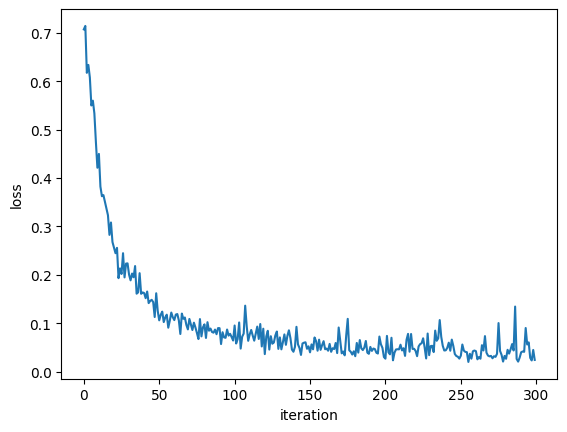

In [15]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [16]:
misclassified_samples = []  # Liste pour stocker les informations des erreurs

# Parcourir tous les batches de validation
for batch_idx, (x_test, y_test) in enumerate(validation_loader):
    with torch.no_grad():
        yhat = model(x_test)
        y_hat = torch.argmax(yhat, dim=1)

    # Trouver les indices des erreurs
    misclassified_indices_batch = (y_hat != y_test).nonzero(as_tuple=True)[0]

    # Ajouter les échantillons mal classés à notre liste
    for idx in misclassified_indices_batch:
        misclassified_samples.append({
            "sample": batch_idx * validation_loader.batch_size + idx.item(),
            "predicted_value": y_hat[idx].item(),
            "actual_value": y_test[idx].item()
        })

    # Arrêter dès qu'on a 4 erreurs
    if len(misclassified_samples) >= 4:
        break  # Stopper complètement si on a 4 erreurs

# Affichage des informations des 4 premières erreurs trouvées
if len(misclassified_samples) > 0:
    for sample in misclassified_samples[:4]:
        print(f"Sample {sample['sample']} predicted value: {sample['predicted_value']} actual value: {sample['actual_value']}")
else:
    print("Aucune erreur trouvée après avoir parcouru tous les batches.")


Sample 94 predicted value: 0 actual value: 1
Sample 102 predicted value: 0 actual value: 1
Sample 315 predicted value: 1 actual value: 0
Sample 347 predicted value: 1 actual value: 0
